# mcb112 week 11 pset


In [1]:
# imports!
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## 1. reproduce Waston's K-means result

#### parse the data file
The data file has a `.tbl` extension similar to the week 10 pset.
The data for the 200 single cell RNA-seq experiments are in tidy format, where each gene is a column and each observation is a row. 

In [2]:
# parse the data
data = pd.read_csv('w11-data.tbl', sep=r'\s+')
# log the data
data = data.map(lambda x: np.log(x) if x > 0 else np.log(1e-6)) # avoid taking log of 0
data

arugula  blueberry   cabbage  chickpea  clementine  cranberry  honeydew  \
0    5.327876   5.389072  6.276643  5.564520    5.680173   5.533389  6.793466   
1    6.021023   6.165418  6.169611  6.184149    5.420535   5.924256  7.181592   
2    5.327876   6.431331  6.796824  5.587249    6.408529   4.890349  7.268920   
3    4.553877   6.336826  6.946014  6.035481    5.198497   5.231109  5.942799   
4    5.497168   6.274762  6.224558  6.304449    6.285998   5.973810  6.812345   
..        ...        ...       ...       ...         ...        ...       ...   
195  5.852202   5.863631  6.525030  6.708084    6.192362   5.556828  7.010312   
196  5.351858   5.627621  6.369901  6.777647    6.448889   5.003946  6.714171   
197  4.248495   5.950643  6.152733  6.863803    6.322565   4.682131  7.396335   
198  5.049856   6.025866  6.496775  6.908755    5.755742   5.602119  7.104965   
199  4.418841   7.128496  6.687109  7.431300    5.036953   5.874931  7.548556   

     mulberry   mustard     onion  ...     H2BFS      PDXK  C21orf33  \
0    5.365976  4.955827  5.117994  ...  3.761200  4.543295  6.269096   
1    6.639876  4.905275  5.594711  ...  4.682131  4.836282  6.703188   
2    5.710427  4.919981  6.244167  ...  4.634729  5.135798  6.068426   
3    6.639876  4.553877  5.808142  ...  4.276666  4.700480  6.421622   
4    6.113682  5.697093  6.175867  ...  4.852030  4.330733  6.542472   
..        ...       ...       ...  ...       ...       ...       ...   
195  5.932245  5.247024  5.488938  ...  4.584967  4.584967  6.651572   
196  5.433722  4.442651  5.293305  ...  3.526361  4.304065  5.913503   
197  5.846439  4.890349  6.037871  ...  4.406719  4.634729  5.327876   
198  6.093570  4.499810  6.249975  ...  4.262680  2.708050  6.175867   
199  6.045005  4.605170  5.549076  ...  5.587249  5.214936  6.431331   

         PFKL  KRTAP10-8   SLC19A1  SLC19A1.1  AC136352.2  AC136352.2.1  \
0    5.003946   6.555357  6.674561   5.135798    5.273000      6.906755   
1    5.153292   7.231287  7.039660   5.236442    5.398163      6.173786   
2    5.624018   6.481577  6.830874   5.389072    6.280396      7.016610   
3    6.035481   6.924612  6.122493   5.214936    5.455321      7.734559   
4    5.996452   7.136483  5.662960   5.894403    4.948760      7.427739   
..        ...        ...       ...        ...         ...           ...   
195  5.135798   5.973810  6.778785   6.161207    4.369448      6.797940   
196  6.436150   7.178545  6.944087   6.016157    5.273000      6.709304   
197  6.052089   6.405228  6.075346   5.720312    5.693732      7.559559   
198  5.905362   7.119636  6.490724   5.700444    5.446737      7.156956   
199  6.246107   6.311735  7.234177   5.666427    5.170484      6.444131   

     AL592183.1  
0      6.224558  
1      6.023448  
2      6.152733  
3      5.752573  
4      6.049733  
..          ...  
195    6.910751  
196    6.322565  
197    6.989335  
198    6.609349  
199    5.755742  

[200 rows x 2001 columns]

Our K-means clustering procedure expects a numpy array as input so let's convert our dataframe to a numpy array called `X` (wow what a descriptive variable name).

In [3]:
# convert data to a numpy array called X
X = data.values
X.shape # check the shape of the numpy array to make sure it is (200,2001)

(200, 2001)

### K-means clustering procedure (modified from week 9)

#### Initialization step

In [4]:
def initialize_centroids(X, k):
    """
    Initialize k centroids by randomly assigning points to k clusters, 
    then calculating the mean of points in each cluster to get initial centroids.

    inputs:
        - X: array of shape (N, g), the observed data points
        - k (int): number of clusters

    outputs:
        - centroids: array of shape (k, g). the initial centroids
    """
    # randomly assign each point to a cluster (0, to k-1)
    cluster_assignments = np.random.randint(0, k, size = len(X))

    # calculate the centroids as the mean of points in each cluster
    centroids = np.array([X[cluster_assignments == cluster_idx].mean(axis=0) for cluster_idx in range(k)])

    return centroids

#### K-means assignment step
$K$ clusters are created by assigning each data point $X_i$ to the nearest centroid $\mu_k$ based on their Euclidian distance in $g$ dimensions $\sqrt{\sum_{g} (X_{ig}-\mu_{kg})^2}$. 

The `assignment` function will (1) calculate the Euclidean distance between each point and each centroid, storing the distances in a 2D array (distances), where each row is a data point and each column is a centroid; (2) assign clusters by finding the index of the closest centroid for each point; and (3) calculate the total squared distance. 

In [5]:
def assignment(X, centroids):
    """
    Assign each point to the closest centroid, calculating the closest center with argmin.

    inputs:
        - X: array of shape (N, g=2), the data points (expression levels of defA and kilA)
        - centroids: array of shape (k, g=2), the current centroids for each cluster

    output:
        - clusters (list): cluster assignment for each point in X
        - total distance (float): total squared euclidean distance from each point to its assigned centroid.
    """
    # calculate distances between each point and each centroid
    # distances = np.array([[np.sqrt(np.sum((point - centroid)**2)) for centroid in centroids] for point in X])
    # distances is a 2D array where each row corresponds to a data point and each column to a centroid

    distances = np.array([[np.sum((point - centroid)**2) for centroid in centroids] for point in X])
    
    # assign each point to the closest centroid
    clusters = np.argmin(distances, axis = 1)
    
    # count points in each cluster
    cluster_counts = {i: 0 for i in range(len(centroids))}
    for cluster in clusters:
        cluster_counts[cluster] += 1
   
    # calculate total squared distance
    min_distances = np.min(distances, axis = 1)
    # total_distance = np.sum(min_distances**2)
    total_distance = np.sum(min_distances)

    return clusters, total_distance

#### K-means update step
`update` function: The centroid of the clusters are updated by calculating the mean of all points assigned to that cluster using $$\mu_{kg}=\frac{\sum_{i\in{C_k}} X_{ig}}{|C_k|}$$

In [6]:
def update(X, clusters, k):
    """
    Update cluster center by calculating the mean position of points assigned to each cluster.
    """
    G = X.shape[1]
    clusters = np.asarray(clusters)

    # initialize an array to store updated centroids
    centroids = np.zeros((k, X.shape[1]))

    # calculate update centroids by averaging points in each cluster
    for cluster_idx in range(k):
        # check if there are points asigned to the cluster
        if np.any(clusters == cluster_idx):
            centroids[cluster_idx] = X[clusters == cluster_idx].mean(axis=0) # update centroid with the mean of assigned points
        else:
            # if cluster has no assigned points, reinitialize centroid randomly
            centroids[cluster_idx] = X[np.random.choice(X.shape[0])]
    
    return centroids

#### convergence
I'll borrow Sean's `diff_assignments` to return the number of assignments that differ between k-means iterations to use as a convergence criterion.

In [7]:
def diff_assignments(a1, a2):
    """
    Returns the number of assignments that differ between <a1> and <a2>,
    where these are, e.g., a1[i] = 0..K-1, a cluster assignment for each cell i.
    """
    N     = len(a1)
    ndiff = 0
    for i in range(N):
        if a1[i] != a2[i]: 
            ndiff += 1
    return ndiff

In [8]:
def k_means(X, k=8, max_iter = 100):
    """
    Run k-means clustering algorithm

    inputs:
        - X (array of shape (N, G)): count data for each cell i...N, for each gene g
        - k (int): number of clusters

    outputs:
        - centroids, clusters, total_distance
    """
    centroids = initialize_centroids(X, k)
    prev_centroids = np.zeros_like(centroids)
    iterations = 0
    convergence = False
    tot_distances_list = []
    prev_assignments = None

    while iterations < max_iter:
        # assignment step
        clusters, total_distance = assignment(X, centroids)
        tot_distances_list.append(total_distance)

        # Check for convergence based on assignment changes
        if prev_assignments is not None:
            ndiff = diff_assignments(clusters, prev_assignments)
            if ndiff == 0:
                # If no assignments have changed, stop the algorithm
                # print(f"Converged after {iterations} iterations")
                break

        # update centroids based on current assignment
        prev_centroids = centroids.copy()
        centroids = update(X, clusters, k)

        # store current assignments for comparison in the next iteration
        prev_assignments = clusters.copy()

        iterations += 1

    return centroids, clusters, total_distance, iterations

In [9]:
def k_means_multi_run(X, k=8, max_iter = 100, n_runs = 20, verbose = True):
    """
    Run k-means clustering algorithm

    inputs:
        - X (array of shape (N, G)): count data for each cell i...N, for each gene g
        - k (int): number of clusters

    outputs:
        - centroids, clusters, total_distance
    """
    best_centroids = None
    best_clusters = None
    best_total_distance = float('inf')

    for run in range(n_runs):
        # run K-means algorithm
        centroids, clusters, total_distance, iterations = k_means(X, k=k, max_iter=max_iter)
        
        # update best results if this run has a lower total distance
        if total_distance < best_total_distance:
            best_total_distance = total_distance
            best_centroids = centroids
            best_clusters = clusters
            best_iterations = iterations + 1

    # Display summary of the best run if verbose is True
    if verbose:
       print(f"\nBest run summary:\nTotal Distance: {best_total_distance}\nIterations: {best_iterations}")

    return best_centroids, best_clusters, best_total_distance

In [10]:
centroids_p1, clusters_p1, tot_dist_p1 = k_means_multi_run(X,k=8)


Best run summary:
Total Distance: 88286.973906631
Iterations: 10


## 2. reduce the dimensionality
Goal: use singular value decomposition to find the principal components of the data set.

#### center the data
We will center the data by subtracting the column mean in each dimension. 
$$
x^*_{ij} = x_{ij} - \bar x_j
$$

In [11]:
# center the data
column_means = np.mean(X, axis=0) # calculate means of each column
X_star = X - column_means # subtract means from X

### using `np.linalg.svd()` to decompose our data
`np.linalg.svd()` will give us: 

$$
X = US_{1D}W^T
$$

where...

* $U$: Each column is a principal component (PC), each row gives corresponding score for each observation (cell)
* $S_{1D}$ vector of singular values which we can turn into the diagonal matrix of singular values when necessary. The singular values tell use the variance explained by each principal component (they are related to the eigenvalues). 
* $W^T$: Each row is a principal component, and the values in each row are the contributions of each gene to that component. We can take the transpose of $W^T$ to get $W$ which gives us our eigenvectors as columns.

In [12]:
U, S_1d, Wt = np.linalg.svd(X_star, full_matrices = False)
# quick check that everything is the right shape
print(f"Shapes -- U: {U.shape}, S(1D): {S_1d.shape}, Wt: {Wt.shape}")
W = Wt.T # take the transpose to get W
n, p = X_star.shape

# convert singular values to eigenvalues
lambdas = np.square(S_1d)/(n-1) # square each element of S

Shapes -- U: (200, 200), S(1D): (200,), Wt: (200, 2001)


Now that we've done SVD, we can project our centered data onto PC-space. 

In [13]:
# project data onto PC space
Y = X_star@W # Y is the projected data yay

Let's examine the first two principle components. Take the $q=2$ leading columns of $W$ and then get $Y_q=X^*W_q$

In [14]:
q = 2 # number of q principal components
Wq = W[:,:q] # grab the columns (eigenvectors) for the first 2 PCs
Yq = X_star@Wq # scores of the data projected onto q PCs

In [15]:
def plot_labelled_scatter(X, clusters=None, xlabel='x1', ylabel='y1', title='Scatterplot'):
    """
    Plot the projected data, colored by cluster (if applicable)

    inputs:
        X (array of shape (n, 2)): data to plot
        clusters (array of shape (n,): cluster assignments
        xlabel (str): label for x axis
        ylabel (str): label for y-axis
        title (str): title of the plot
    """
    # if no clusters are passed, set clusters to be zero
    if clusters is None:
        clusters = np.zeros(X.shape[0])

    # colormap from matplotlib
    cmap = plt.get_cmap('tab20b', len(np.unique(clusters)))

    # plotting
    fig, ax = plt.subplots()
    scatter = ax.scatter(X[:, 0], # PC1
                         X[:, 1], # PC2
                         c=clusters,  # cluster labels for coloring
                         cmap=cmap, 
                         alpha=0.7,
                         edgecolors='none')

    # add color bar if clusters provided
    if len(np.unique(clusters)) > 1:
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label("Cluster Label")

    # the labels and stuff
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    
    plt.show()

### Plot all 200 cells in 2D PCA space using their projections onto the first two principal axes.

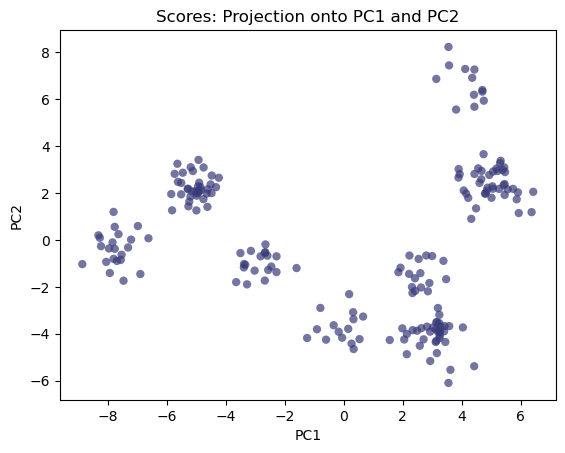

In [16]:
plot_projected = plot_labelled_scatter(Yq, xlabel='PC1', ylabel='PC2', title = 'Scores: Projection onto PC1 and PC2')

Amazing! When we project our data onto the first 2 principal axes, we can visually see 8 distinct clusters. 

### was watson right to expect 8 clusters?
Plot the eigenvalues for each component, and justify why you're pretty sure it would be hard to find any other clusters in the data set. 

In [17]:
# load in the negative data
negative_data = pd.read_csv('w11-eigen.tbl', sep=r'\s+', header = None)
negative_data

0      1
0      PC1  3.859
1      PC2  3.770
2      PC3  3.722
3      PC4  3.700
4      PC5  3.669
..     ...    ...
194  PC195  1.151
195  PC196  1.138
196  PC197  1.124
197  PC198  1.097
198  PC199  1.075

[199 rows x 2 columns]

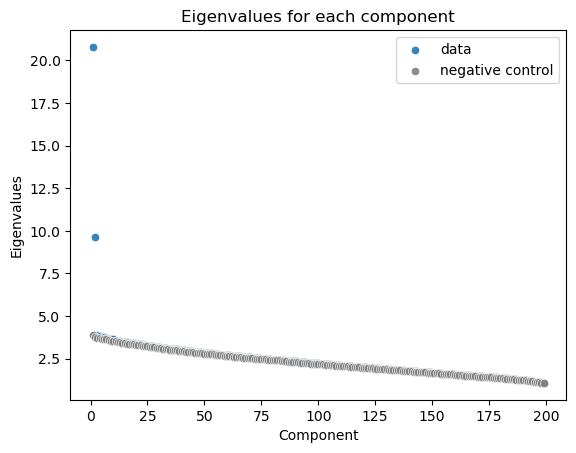

In [18]:
# plotting the eigenvalues for each component
xvals = 1+np.arange(n-1)
fig, ax = plt.subplots()

# plot the real data
sns.scatterplot(x=xvals, y=lambdas[:-1], marker='o', label='data', alpha=0.9, ax=ax) 

# plot the negative control eigenvalues
sns.scatterplot(x=xvals, y=negative_data[1].values, marker='o', label = 'negative control', color = 'gray', alpha = 0.9, ax=ax)

# labels
ax.set_ylabel('Eigenvalues')
ax.set_xlabel('Component')
ax.set_title('Eigenvalues for each component')
plt.show()

The eigenvalues represent the amount of variance is captured by each principal component. We can see from the above plot that only two of the eigenvalues are higher compared to the negative control (the rest of our eigenvalues from the data lie directly beneath the negative control data). The simulated negative control data set has no correlations between any of the genes and there are no cell types, so it's basically just representing the eigenvalues we would expect to see from noise.

This means we can be confident that the majority of the real variance in our data is captured in those first two principal components. Therefore, it would be hard to find any other clusters in the data set because the other principal components don't capture relevant variance in the data. Taken together, Watson was correct to assume 8 clusters (cell types)!

### how many genes?
Based on the eigenvector loadings, how many genes appear to influence cell type identity? Explain.

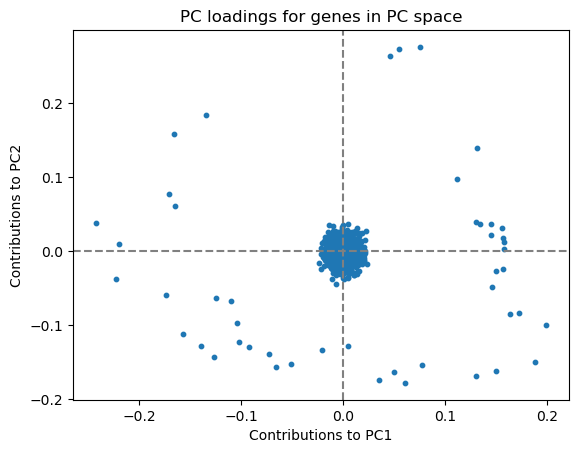

In [19]:
# plot the eigencvector loadings
fig, ax = plt.subplots()

ax.scatter(W[:,0],W[:,1],s=10) 
ax.axvline(x=0, color='gray', linestyle='--')
ax.axhline(y=0, color='gray', linestyle='--')
ax.set_xlabel('Contributions to PC1')
ax.set_ylabel('Contributions to PC2')
ax.set_title('PC loadings for genes in PC space')
plt.show()

Cool, most of our genes are around zero, so they are not contributing much to PC1 or PC2.

Okay but what if I want to calculate proportion of variance in PC1 and PC2 due to each individual gene $i$. What's the variance contribute of each gene? For a gene $i$ in a PC $j$, the variance contribution is $\lambda_j * w^2_{ij}$ where...

* $\lambda_j$: eigenvalue for PC $j$
* $w_{ij}$: loading for gene $i$ on PC $j$ from $W_q$

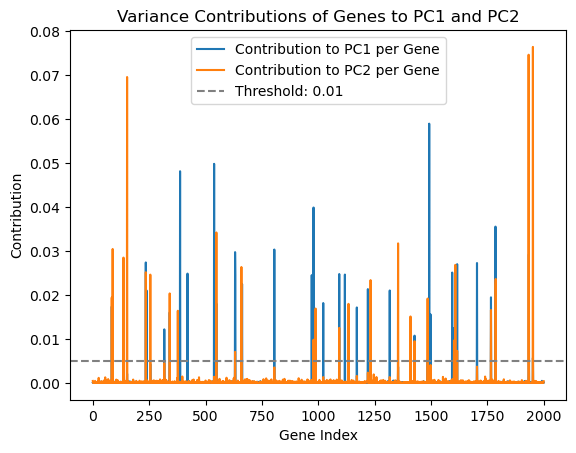

In [20]:
# grab the eigenvalues (variance explained) for PC1 and PC2
lambda_1 = lambdas[0] # PC1
lambda_2 = lambdas[1]

# loadings for PC1 and PC2
PC1 = Wq[:,0]
PC2 = Wq[:,1]

var_contr_PC1 = lambda_1 * (PC1**2)
var_contr_PC2 = lambda_2 * (PC2**2)

prop_contr_PC1 = var_contr_PC1 / lambda_1
prop_contr_PC2 = var_contr_PC2 / lambda_2

fig, ax = plt.subplots()
ax.plot(prop_contr_PC1, label='Contribution to PC1 per Gene')
ax.plot(prop_contr_PC2, label='Contribution to PC2 per Gene')
ax.axhline(0.005, color = 'gray', linestyle='--', label = f"Threshold: {0.01}")
ax.set_xlabel('Gene Index')
ax.set_ylabel('Contribution')
ax.set_title('Variance Contributions of Genes to PC1 and PC2')
plt.legend()
plt.show()

Woah! Okay, the majority of the 2001 genes have extermely tiny contributions to PC1 and PC2 (that's our noise) and it looks like the 'influential' genes all capture at least 0.5% of the variance so that seems like a decent cutoff. 

In [21]:
# set a threshold of contributions > 0.5% of variance in PC2 or PC2
threshold_1 = 0.005 * lambda_1
threshold_2 = 0.005 * lambda_2

# what are the influental(relevant) genes
relevant_PC1 = np.where(var_contr_PC1>threshold_1)[0]
relevant_PC2 = np.where(var_contr_PC2>threshold_2)[0]

# combine and identify unique genes
relevant_genes = np.unique(np.concatenate([relevant_PC1,relevant_PC2]))

print(f"Number of 'influential' genes: {len(relevant_genes)}\n")
print(f"Indices of 'influential' genes: {relevant_genes}")

Number of 'influential' genes: 47

Indices of 'influential' genes: [  84   88  136  152  235  238  255  317  341  377  387  420  538  548
  631  632  659  662  805  971  979  988 1022 1093 1118 1134 1171 1220
 1232 1317 1354 1409 1427 1485 1492 1498 1594 1602 1608 1616 1704 1766
 1786 1787 1933 1934 1952]


Okay, based on the eigenvector loadings, **47 genes** appear to influence cell type identity. Why? First, we observed that PC1 and PC2 explain the majority of the variance in our data, making them the most informative components. Then, we analyzed the contributions of each individual gene to the variance in PC1 and PC2, and we saw that the majority of the 2001 genes had very low contributions—they accounted for a very tiny proportion of the total variance in PC1 or PC2. However, 47 genes stood out with contributions that were significantly above this background noise, suggesting they are important to defining cell type.

## 3. check the clustering

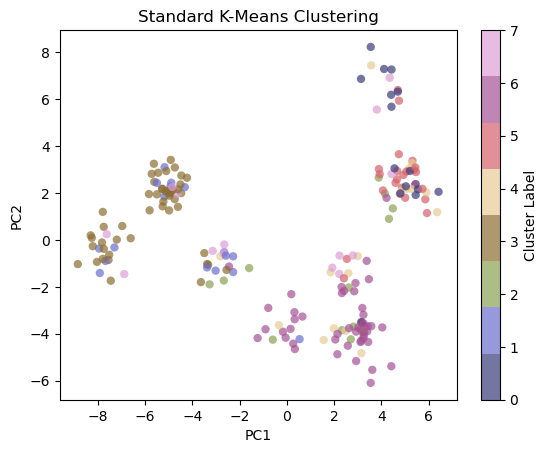

In [22]:
plot_labelled_scatter(Yq, clusters=clusters_p1, xlabel='PC1', ylabel='PC2', title = 'Standard K-Means Clustering')

#### Explanation
**Offer an explanation of what might be going wrong, and find a way to cluster so that each cell appears properly assigned in PC space.**

Standard K-means struggles if the data is not well-separated by Euclidean distances. With high-dimensional data (e.g. 2001 genes), distances between points become less meaningful because many of the variables (genes) introduce noise, making the clusters less distinguishable. 

Additionally, K-means assumes that the clusters are spherical and have similar sizes. However, in our data, variance is concentrated in certain dimensions, meaning the clusters are not necessarily spherical or evenly distributed. PCA would help by reducing the dimensionality and bringing out the meaningful directions (principal components) that have the most variance. K-means struggles to handle  different amounts of variance across different dimensions. 

Essentially, in a 2001-dimensional space, the true signal defining our cell types is lost in a lot of noise because many fo the dimensions don't contribute to cell type. **Standard K-means doesn't have a way to determine which dimensions are informative and which are not.**

Instead of trying to cluster on the 2001-dimensional data, we should run K-means clustering on the first two principal components (PC1 and PC2). We reduced the dimensionality of our data to the most informative components, which reduces noise. In PC space, the data is better separated along the dimensions that have the highest variance, making it easier for K-means to identify distinct groups.

In [23]:
# run k-means clustering on the data projected to PC-space for the first two PCs
# basically clustering on the scores 
centroids_pc, clusters_pc, total_distance_pc = k_means_multi_run(Yq, k=8) # Yq is our data projected onto PC1 and PC2 


Best run summary:
Total Distance: 130.56501825299569
Iterations: 12


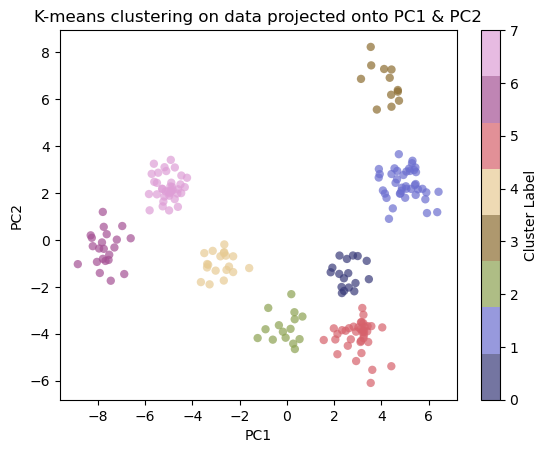

In [24]:
# plot the results
plot_labelled_scatter(Yq, clusters=clusters_pc, xlabel='PC1', ylabel='PC2', title = 'K-means clustering on data projected onto PC1 & PC2')

Indeed, K-means worked on $Y_q$ (the data projected onto PC1 and PC2) as we can see from the colored clusters in the plot above. 

Notes for me: projections onto PC1 and PC2 are the scores of each sample along those principal components Scores represent the linear combinations of the original variables that best explain the variance in the data. The scores are in the PCA-transformed space.

## 4. reconstruct the expression patterns
Reconstruct the original data set using only the projected data and eigenvectors for the first 2 principal components. Visualize the data using a heat map. Do the clusters now look more obvious? Why or why not?

In [25]:
def plot_data_heatmap(X, title, relevant_genes=None, x_labels='Cells #'):
    """
    Plot a heatmap of the data X
    
    input:
        X (array of shape (n,p): Numpy array  matrix with n observations (rows) and p variables (columns),
            your data to plot
        title (str): desired title of the heatmap
        relevant_genes: List of relevant gene indices to use for x-tick labels (optional)
        x_labels (str): how to label the x-axis
    """
    vmin, vmax = np.min(X), np.max(X)  
    fig, ax = plt.subplots(figsize=(16, 6))
    
    # heatmap
    sns.heatmap(X, cmap='Purples', vmin=vmin, vmax=vmax, ax=ax)

    # labels 
    ax.set_ylabel(x_labels)
    ax.set_xlabel('Gene #')
    ax.set_title(f"{title}")

    # update x-tick labels if relevant genes are provided
    if relevant_genes is not None and len(relevant_genes) > 0:
        ax.set_xticks(range(len(relevant_genes)))  
        ax.set_xticklabels(relevant_genes, rotation=90)

    plt.tight_layout()
    plt.show()

For comparison, let's make a heatmap of the centered data $X^*$ before doing PCA.

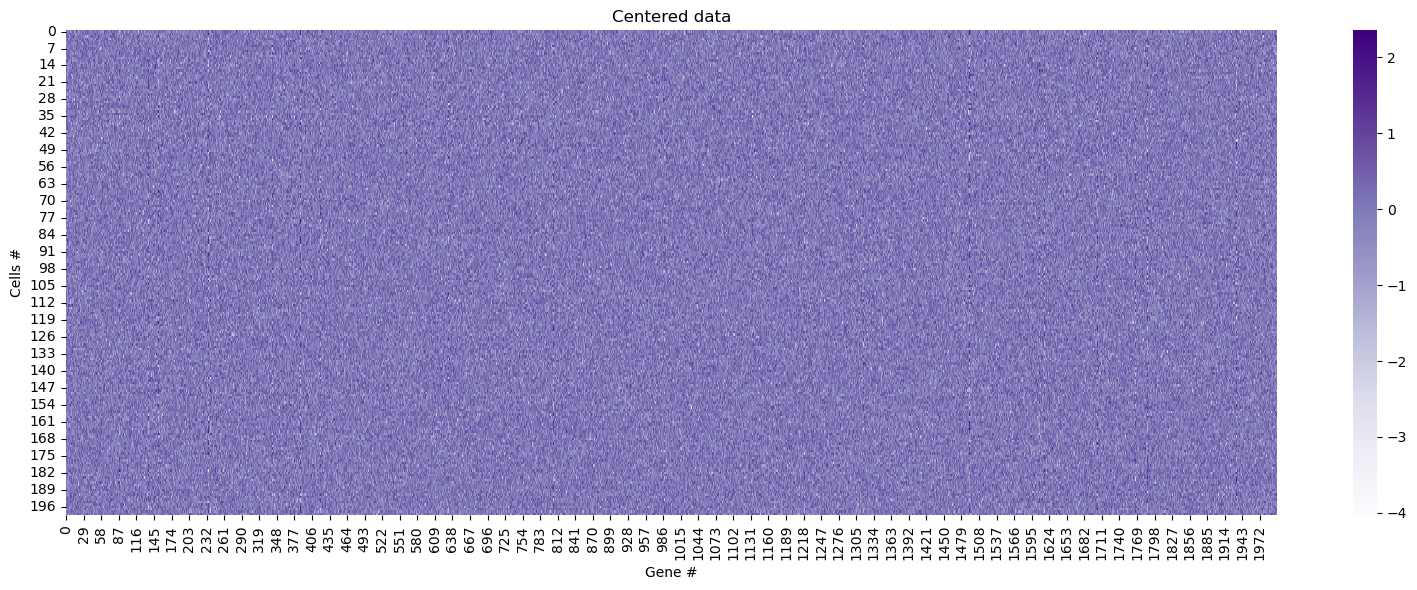

In [26]:
# Our centered data before PCA
plot_data_heatmap(X_star, 'Centered data')

Oh how beautiful! Before PCA, our data look uninterpretable. Let's reconstruct $X^*$ (the original centered data) with variance from q=2 dimensions (using the projected data and eigenvectors for the first two PCs).

In [27]:
# grabbing the first q=2 PCs
U_q = U[:, :q] # scores for the top q PCs
S_diag = np.diag(S_1d) # convert singular values to diag matrix
S_q = S_diag[:q,:q] # keep top q SVs
Wt_q = Wt[:q, :] # 

# reconstruction using the top q principal components
X_q_star = U_q @ S_q @ Wt_q # in centered space!

# uncenter the reconstructed data
X_q = X_q_star + column_means # column means are making a comeback 

In [28]:
# it will probably be easier to see the clusters in the plot if we group cells in the same cluster on the plot
# i'm lazy and i don't want to sort with numpy so i'm going to turn my X_q into a dataframe
Xq_df = pd.DataFrame(X_q_star)

# add a column in the dataframe for the clusters
# clusters_pc lists the cluster of each cell and the indices match the cell (observations) indices in Xq
Xq_df['Cluster'] = clusters_pc 

# now we can sort by cluster
sorted_Xq = Xq_df.sort_values(by='Cluster').reset_index(drop=True)

In [29]:
# convert back to an array and get rid of the cluster column
new_sorted_Xq = sorted_Xq.drop(columns=['Cluster'])
sorted_Xq_array = new_sorted_Xq.values

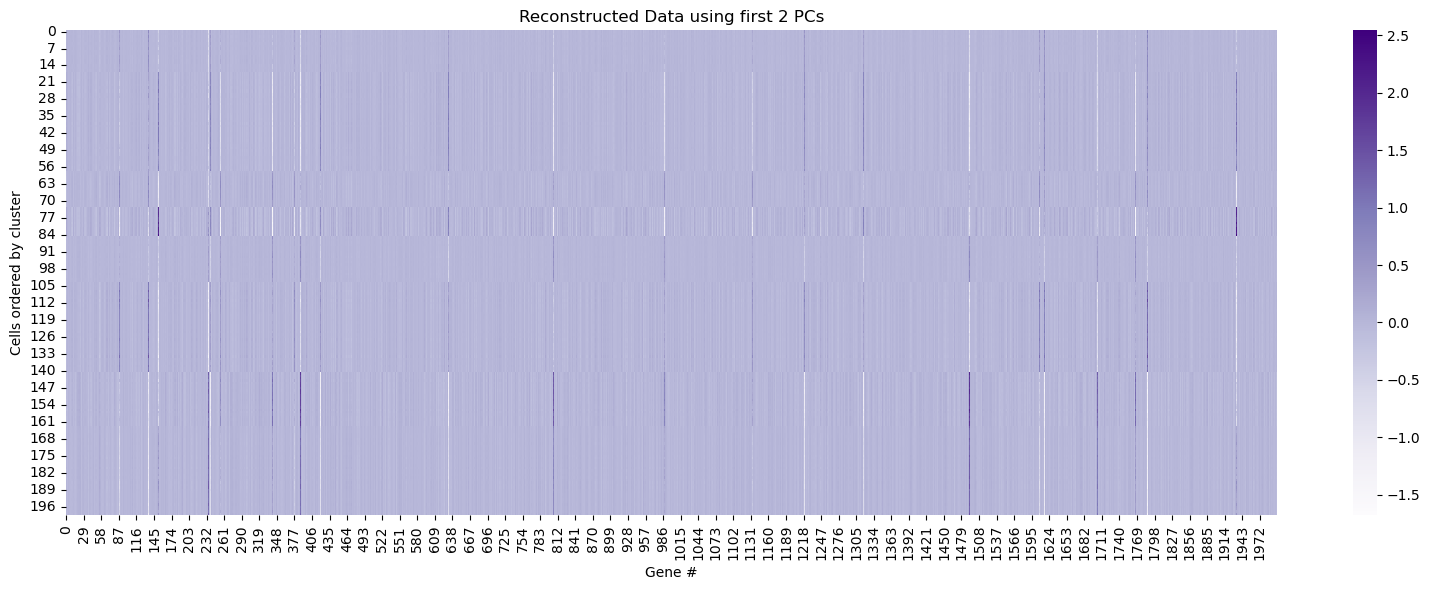

In [30]:
plot_data_heatmap(sorted_Xq_array, title = 'Reconstructed Data using first 2 PCs', x_labels='Cells ordered by cluster')

Alright, okay if I squint really hard, I can maybe see 8 clusters (breaks in the rows). But honestly, it is difficult to see them. The majority of the data appears faint, with only slight hints of variation across columns. In the plot above, I'm plotting all the genes, but we already decided that all but 47 of the genes are largely irrelevant for determining cell type. Our signal is buried in noise from all the unimportant genes, making it hard to see patterns in the above heatmap of our reconstructed data. 

Let's instead filter the $X_q$ to only look at relevant genes.

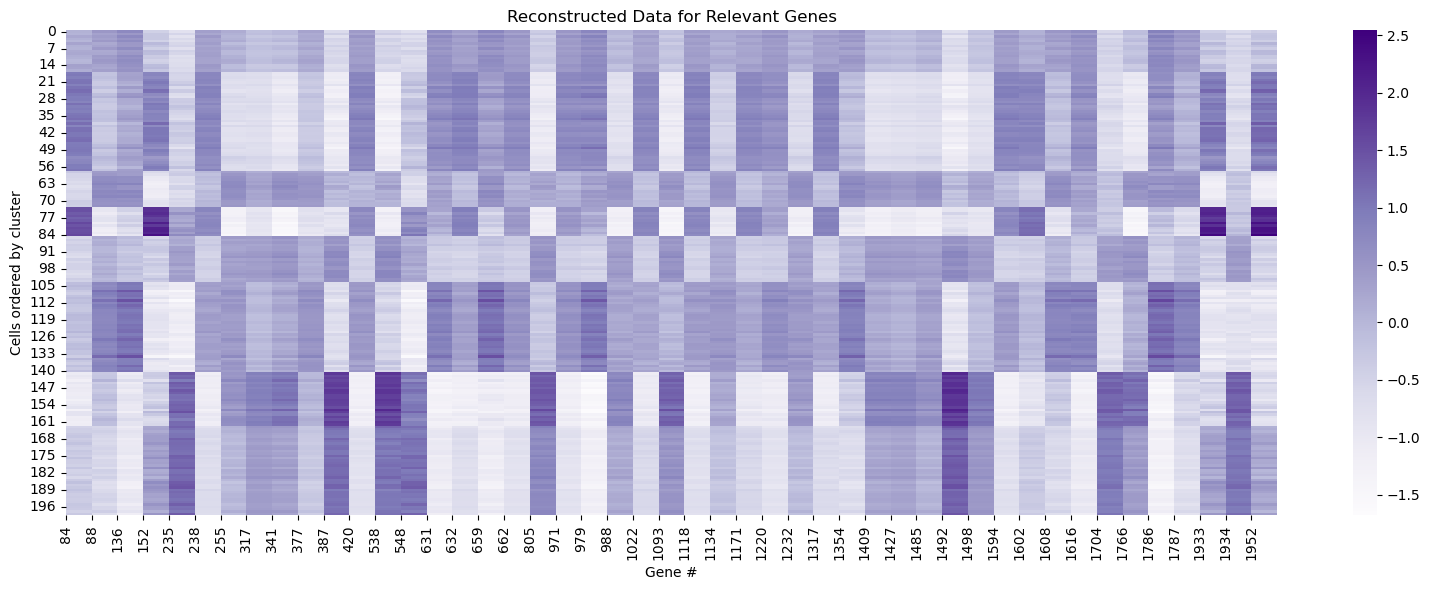

In [31]:
# filter X_q to only have relevant genes
filtered = sorted_Xq_array[:,relevant_genes]
# plot it
plot_data_heatmap(filtered, title = 'Reconstructed Data for Relevant Genes', relevant_genes = relevant_genes, x_labels='Cells ordered by cluster')

Okay, woah! I think I see 8 clusters (separations between rows). By filtering for the genes that are actually informative for distinguishing between cell types, the clusters are more visually identifiable. 

I want to try adding horizontal lines on top of the heatmap to delineate the clusters. I'll do this in `plot_data_heatmap_2`.

In [32]:
def plot_data_heatmap_2(X, title, relevant_genes=None, clusters=None, x_labels='Cells #'):
    """
    Plot a heatmap of the data X with x-tick labels replaced by relevant genes,
    an optional cluster color bar on the left, and horizontal lines to delineate clusters.

    input:
        X (array of shape (n,p): Numpy array  matrix with n observations (rows) and p variables (columns),
            your data to plot
        title (str): desired title of the heatmap
        relevant_genes: List of relevant gene indices to use for x-tick labels (optional)
        clusters: List or array of cluster assignments for the rows (optional)
        cell_labels (Bool) whether to label cluster specifically if you had cluster (cell type) assignments
    """
    vmin, vmax = np.min(X), np.max(X) 
    fig, ax = plt.subplots(figsize=(16, 6))

    # heatmap
    sns.heatmap(X, cmap='Purples', vmin=vmin, vmax=vmax, ax=ax, cbar=True)

    # horizontal lines to delineate clusters
    if clusters is not None:
        sorted_indices = np.argsort(clusters) # get the indices of sorted clusters
        clusters = np.array(clusters)[sorted_indices] # sort the clusters
        unique_clusters, cluster_boundaries = np.unique(clusters, return_index=True) # get the index where cluster changes
        for boundary in cluster_boundaries[1:]:  # skip the first boundary (0)
            # add a horizontal line at cluster boundaries
            ax.hlines(boundary, xmin=0, xmax=X.shape[1], colors='black', linewidth=1)

    # labels and stuff
    ax.set_ylabel(x_labels)
    ax.set_xlabel('Gene #')
    ax.set_title(f"{title}")

    # update x-tick labels if relevant genes are provided
    if relevant_genes is not None and len(relevant_genes) > 0:
        ax.set_xticks(range(len(relevant_genes)))
        ax.set_xticklabels(relevant_genes, rotation=90)

    plt.show()


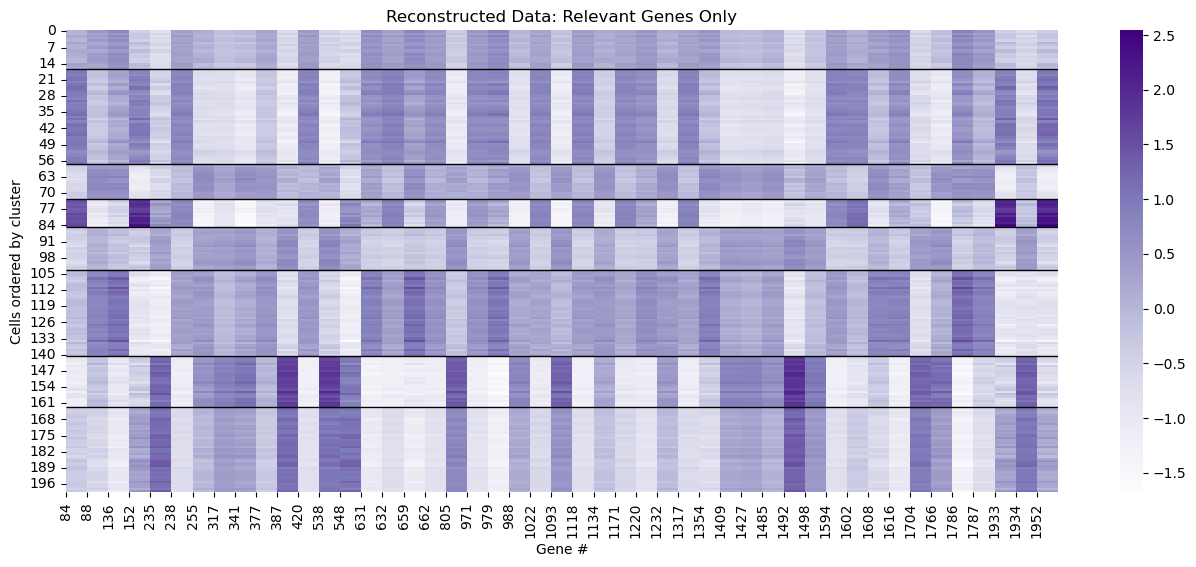

In [33]:
plot_data_heatmap_2(filtered, title='Reconstructed Data: Relevant Genes Only', relevant_genes=relevant_genes, clusters=clusters_pc, x_labels='Cells ordered by cluster')

Cool, when we look at the reconstructed expression patterns for the genes relevant to determining cell type we get 8 distinct clusters. Thanks PCA!

In [34]:
%load_ext watermark
%watermark -v -m -p jupyter,numpy,matplotlib

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.27.0

jupyter   : 1.1.1
numpy     : 2.1.1
matplotlib: 3.9.2

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 11
Architecture: 64bit

